In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot  as plt 
import pickle
import re
from sklearn.metrics import accuracy_score,fbeta_score,classification_report
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')


C:\Users\erpagho\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Import  NLP packages###


In [2]:
import nltk
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
ss = SnowballStemmer("english")
ps = PorterStemmer()
from nltk.corpus import stopwords
nltk.download("stopwords")
stop = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erpagho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
msg_df = pd.read_csv('spam.csv',sep ='\t',names = ['label','message'])

In [8]:
msg_df.shape

(5572, 2)

In [13]:
len(stop)
#stop

179

In [15]:
msg_df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [19]:
msg_df.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

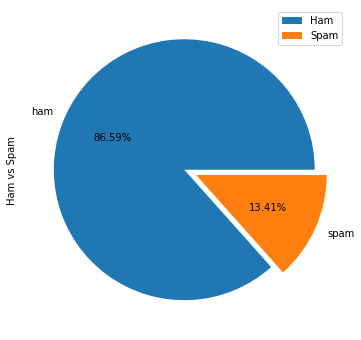

In [21]:
msg_df['label'].value_counts().plot(kind = 'pie',explode = [0,0.1],figsize = (6,6),autopct = '%1.2f%%')
plt.ylabel('Ham vs Spam')
plt.legend(['Ham','Spam'])
plt.show()

In [17]:
msg_df['length'] = msg_df['message'].apply(len)
msg_df.head()

,label,message,length
0,1,go jurong point crazi avail bugi n great world...,76
1,1,ok lar joke wif u oni,21
2,0,free entri wkli comp win fa cup final tkts st ...,100
3,1,u dun say earli hor u c alreadi say,35
4,1,nah think goe usf live around though,36


** data cleaning**

In [4]:
import string

In [5]:
def cleanText(message):
    message = re.sub('[^a-zA-Z]',' ',message)
    message = message.lower()
    message = message.split()
    words = [ss.stem(word) for word in message if word not in stop]
    return " ".join(words)

In [6]:
msg_df['message'] = msg_df['message'].apply(cleanText)

In [8]:
msg_df.head()
msg_df.shape

(5572, 2)

In [9]:
## apply category to ham/spam - 0/1
def encode_category(cat):
    if cat == 'ham' :
        return 1
    if cat == 'spam':
        return 0

msg_df['label'] = msg_df['label'].apply(encode_category)
    

In [10]:
msg_df.head()

,label,message
0,1,go jurong point crazi avail bugi n great world...
1,1,ok lar joke wif u oni
2,0,free entri wkli comp win fa cup final tkts st ...
3,1,u dun say earli hor u c alreadi say
4,1,nah think goe usf live around though


** Lets convert our clean text into a representation that a machine learning model can understand. 
Bag of Words Techiniques are : #TFIDF #Count Vectorizer

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(encoding = "latin-1", strip_accents = "unicode")
features = vec.fit_transform(msg_df["message"])
print(features.shape)

(5572, 6292)


In [12]:
from sklearn.feature_extraction.text import CountVectorizer
#cv = CountVectorizer()
#X=cv.fit_transform(msg_df["message"])
#print (X.shape)

In [13]:
cv = CountVectorizer()

#X_obj=cv.fit(msg_df["message"])
#X.vocabulary_
#X.get_feature_names()

In [14]:
X = cv.fit_transform(msg_df["message"]).toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [44]:
X.shape

(5572, 6292)

In [93]:
df = pd.DataFrame(X,columns=cv.get_feature_names())


In [94]:
## add length col
#df['len']=msg_df['length']
df.shape


(5572, 6292)

In [95]:
y=msg_df['label']

In [138]:
y .head()

0    1
1    1
2    0
3    1
4    1
Name: label, dtype: int64

In [96]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.20, random_state = 0)

In [97]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(X_train, y_train)

y_pred=spam_detect_model.predict(X_test)

In [98]:
X_test.shape

(1115, 6292)

In [99]:
print(accuracy_score(y_test,y_pred))
print(fbeta_score(y_test,y_pred,beta =0.5))

0.979372197309417
0.9900990099009901


In [154]:
y_pred

array([1, 0, 1, ..., 1, 0, 1], dtype=int64)

In [151]:
print (classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       160
           1       0.99      0.98      0.99       955

    accuracy                           0.98      1115
   macro avg       0.95      0.97      0.96      1115
weighted avg       0.98      0.98      0.98      1115



save model in pickle files and use it later 

In [100]:
# first dump the model using dumps
saved_model = pickle.dumps(spam_detect_model)
# then load the model again sing loads
modelfrom_pickle = pickle.loads(saved_model)


In [101]:
y_pred = modelfrom_pickle.predict(X_test)

In [102]:
print (accuracy_score(y_test,y_pred))

0.979372197309417


In [103]:
import joblib

** Now we make 2 pickle files - one for model which we will apply on model and another on X which is transform pickle file which 
will convert the input data to numeric form 

In [144]:
joblib.dump(spam_detect_model,'pickle.pkl')
joblib.dump(cv,'transform.pkl')

['transform.pkl']

In [114]:
user_input = "Oh k...i'm watching here:)"

In [145]:
user_input1 = "I know! Grumpy old people. My mom was like you better not be lying. Then again I am always the one to play jokes..."

In [156]:
user_input2 = 'Thanks a lot for your wishes on my birthday. Thanks you for making my birthday truly memorable'

In [146]:
data = [user_input1]

In [147]:
trans_pkl = open("transform.pkl","rb")
prod_transf = joblib.load(trans_pkl)

clf_vect_tfidf= open("pickle.pkl","rb")
prod_clf = joblib.load(clf_vect_tfidf)

In [160]:
vect = prod_transf.transform([user_input2])

In [161]:
vect.shape

(1, 6292)

In [162]:
my_pred = prod_clf.predict(vect)

In [165]:
type(my_pred[0])

numpy.int64

In [166]:
if my_pred == 1 :    
    print('This is not  spam !!!!!!!!!!')
elif my_pred ==0:
    print('BEWARE This is spam')
    

This is not  spam !!!!!!!!!!
